# Multivariate Time Series Forecasting with Transformers 
Dataset: http://bit.ly/covid19-poland

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import networkx
import seaborn
import sklearn
from tabulate import tabulate

## Load dataset

In [2]:
df = pd.read_csv('DataSets/COVID-19_w_Polsce-Wzrost.csv', sep=';', usecols=["Data", "Nowe przypadki", "Zmiana liczby aktywnych przypadków"])
print(df.head())
print(df.tail())
print(f"Number of records: {len(df)}")
print("Labels types:")
print(f"{df.dtypes}")

# table = df.values.tolist()
# headers = df.columns.tolist()
# print(tabulate(table, headers=headers, tablefmt="pretty"))

# styled_df = df.style.format('{:^10}').set_properties(**{'border': '1px solid black', 'text-align': 'center'}).set_table_styles([{'selector': 'th', 'props': [('border', '1px solid black')]}])
# styled_df

   Data Nowe przypadki Zmiana liczby aktywnych przypadków
0  3.03            + 0                                + 0
1  4.03            + 1                                + 1
2  5.03            + 0                                + 0
3  6.03            + 4                                + 4
4  7.03            + 1                                + 1
      Data Nowe przypadki Zmiana liczby aktywnych przypadków
738  11.03        + 11637                              2 917
739  12.03            NaN                          5 169 557
740    NaN            NaN                                NaN
741    NaN            NaN                                NaN
742    NaN            NaN                                NaN
Number of records: 743
Labels types:
Data                                  float64
Nowe przypadki                         object
Zmiana liczby aktywnych przypadków     object
dtype: object


## Data preprocessing

### Remove NaNs

In [3]:
df = df.dropna()
# for index, row in df.iterrows():
#     if pd.isna(row['Data']):
#         df.drop(index, inplace=True)
print(f"Number of records after dropping all NaNs: {len(df)}")
df

Number of records after dropping all NaNs: 739


,Data,Nowe przypadki,Zmiana liczby aktywnych przypadków
0,3.03,+ 0,+ 0
1,4.03,+ 1,+ 1
2,5.03,+ 0,+ 0
3,6.03,+ 4,+ 4
4,7.03,+ 1,+ 1
...,...,...,...
734,7.03,+ 5585,-6 470
735,8.03,+ 13152,2 945
736,9.03,+ 14415,4 355
737,10.03,+ 13438,4 794


### Convert types

In [4]:
def is_string(value):
    return isinstance(value, str)
result = df.applymap(is_string)
print(result)

      Data  Nowe przypadki  Zmiana liczby aktywnych przypadków
0    False            True                                True
1    False            True                                True
2    False            True                                True
3    False            True                                True
4    False            True                                True
..     ...             ...                                 ...
734  False            True                                True
735  False            True                                True
736  False            True                                True
737  False            True                                True
738  False            True                                True

[739 rows x 3 columns]


In [5]:
df

,Data,Nowe przypadki,Zmiana liczby aktywnych przypadków
0,3.03,+ 0,+ 0
1,4.03,+ 1,+ 1
2,5.03,+ 0,+ 0
3,6.03,+ 4,+ 4
4,7.03,+ 1,+ 1
...,...,...,...
734,7.03,+ 5585,-6 470
735,8.03,+ 13152,2 945
736,9.03,+ 14415,4 355
737,10.03,+ 13438,4 794


In [6]:
print(df.dtypes)
typ_komorki = df.at[0, 'Nowe przypadki']

print("Typ komórki:", type(typ_komorki))
#convert columns 'Nowe przypadki' and 'Zmiana liczby aktywnych przypadków' to int
df['Nowe przypadki'] = df['Nowe przypadki'].str.replace(' ', '')
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].str.replace(' ', '')

df['Nowe przypadki'] = df['Nowe przypadki'].astype(int)
df['Zmiana liczby aktywnych przypadków'] = df['Zmiana liczby aktywnych przypadków'].astype(int)

df['Data'] = pd.to_datetime(df['Data'].astype(str), format='%d.%m')
df['Data'] = df['Data'].apply(lambda x: x.replace(year=2020))

Data                                  float64
Nowe przypadki                         object
Zmiana liczby aktywnych przypadków     object
dtype: object
Typ komórki: <class 'str'>


In [7]:
df.tail()

,Data,Nowe przypadki,Zmiana liczby aktywnych przypadków
734,2020-03-07,5585,-6470
735,2020-03-08,13152,2945
736,2020-03-09,14415,4355
737,2020-03-10,13438,4794
738,2020-03-11,11637,2917


# TODO: DOKOŃCZYĆ PREPROCESSING

In [8]:
# TODO: DOKOŃCZYĆ PREPROCESSING



## Visualisation

In [9]:
def visualise():
    plt.figure(figsize=(14, 7))
    plt.plot(df['Data'], df['Nowe przypadki'], label='Nowe przypadki')
    plt.plot(df['Data'], df['Zmiana liczby aktywnych przypadków'], label='Zmiana liczby aktywnych przypadków')
    plt.xlabel('Data')
    plt.ylabel('Liczba przypadków')
    plt.title('COVID-19 w Polsce')
    plt.legend()
    plt.show()

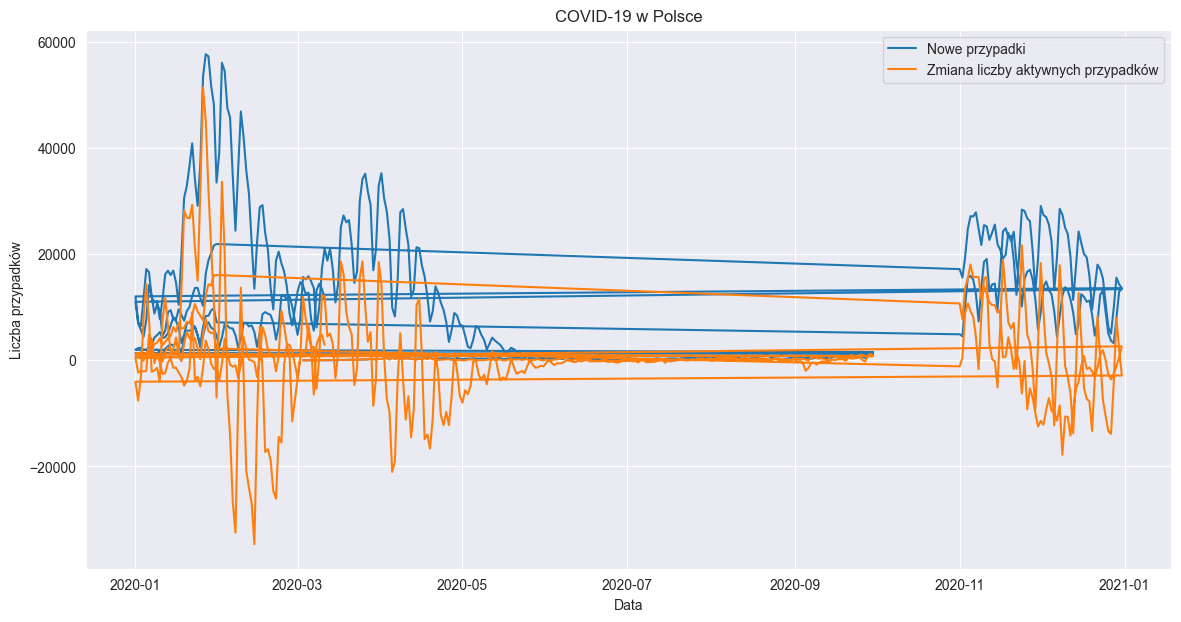

In [10]:
visualise()

## Create Model

In [11]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers=2, hidden_size=64, num_heads=4, dropout=0.1):
        super(TransformerModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, src):
        src = src.permute(1, 0, 2)  # wymagane wymiary [seq_len, batch, input_size]
        output = self.transformer_encoder(src)
        output = self.fc(output[-1, :, :])  # ostatni element z sekwencji
        return output

## Training

In [16]:
# data = df[['Data', 'Nowe przypadki', 'Zmiana liczby aktywnych przypadków']].copy()
# data = df[['Data', 'Zmiana liczby aktywnych przypadków']].copy()

df_nowe = df[['Data', 'Nowe przypadki']].copy()
df_nowe['Data'] = pd.to_datetime(df_nowe['Data'])
df_nowe.set_index('Data', inplace=True)

data = (df_nowe - df_nowe.mean()) / df_nowe.std()

train_nowe = data.iloc[:int(0.8 * len(data))]
test_nowe = data.iloc[int(0.8 * len(data)):]

X_train_nowe = torch.tensor(train_nowe.values, dtype=torch.float32)
X_test_nowe = torch.tensor(test_nowe.values, dtype=torch.float32)
X_train_nowe

tensor([[-7.4727e-01],
        [-7.4717e-01],
        [-7.4727e-01],
        [-7.4689e-01],
        [-7.4717e-01],
        [-7.4679e-01],
        [-7.4670e-01],
        [-7.4679e-01],
        [-7.4641e-01],
        [-7.4536e-01],
        [-7.4565e-01],
        [-7.4383e-01],
        [-7.4526e-01],
        [-7.4230e-01],
        [-7.4144e-01],
        [-7.4259e-01],
        [-7.4077e-01],
        [-7.4058e-01],
        [-7.3666e-01],
        [-7.3790e-01],
        [-7.3628e-01],
        [-7.3274e-01],
        [-7.3293e-01],
        [-7.3102e-01],
        [-7.3121e-01],
        [-7.2347e-01],
        [-7.2586e-01],
        [-7.2882e-01],
        [-7.2280e-01],
        [-7.2404e-01],
        [-7.0980e-01],
        [-7.0550e-01],
        [-7.2395e-01],
        [-7.0187e-01],
        [-7.1754e-01],
        [-7.0569e-01],
        [-7.1315e-01],
        [-7.1190e-01],
        [-7.1095e-01],
        [-7.0894e-01],
        [-7.1687e-01],
        [-7.2261e-01],
        [-7.2146e-01],
        [-7

In [13]:
def train_and_evaluate(model, epochs, criterion, optimizer, X_train, X_test):
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, X_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
        predicted = model(X_test)
        predicted = predicted.detach().numpy()

## Evaluation

In [14]:
input_size = X_train_nowe.shape[2]
output_size =input_size
num_layers = 2
hidden_size = 64
# Parametr num_heads jest jednym z kluczowych hiperparametrów w modelach Transformer używanych w zadaniach przetwarzania sekwencji, takich jak tłumaczenie maszynowe, generowanie tekstu czy modelowanie języka.
# W skrócie, w modelach Transformer, dane są przetwarzane równolegle przez wiele kopii mechanizmu uwagi (ang. attention mechanism). Liczba tych kopii jest określana przez parametr num_heads. Każda z tych kopii, zwana "głową", jest odpowiedzialna za naukę innych relacji między słowami w sekwencji, co pozwala na bardziej elastyczne i równoległe przetwarzanie danych.
num_heads = 4
dropout = .1

model = TransformerModel(input_size, output_size, num_layers, hidden_size, num_heads, dropout)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 100

train_and_evaluate(model=model,
                   epochs=epochs,
                   criterion=criterion,
                   optimizer=optimizer,
                   X_train=X_train_nowe,
                   X_test=X_test_nowe)

IndexError: tuple index out of range

## Conclusion

In [ ]:
# TODO: POLECENIE:
#  Do testowania proszę użyć kilku podejść podziału danych na uczące- testujace:
#  (https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)
#  -K-Fold, Time SeriesSplit, Blocking Time Series Split
#  Dla każdego wyniku stosujemy różne miary błędu (ewaluacji) MSE, MAE, R^2,  specyficzność czułość, index of agreement itp..